### Check global maximum wind velocities

### Check global mean top-of-atmosphere net energy flux
#### Calculate effective planetary temperature

### Calculate the total mass of chemical species in various atmospheric layers

From the ideal gas law, $PV = m R_s T$, the molecular mass of a gas or a mixture of gases is $m = \frac{PV}{R_s T}$.

The molecular mass of the gas i is:

$m_i = \frac{PV}{R_s T}w_i$,

where $w_i$ is the mass fraction of the gas i.

The mass fraction of the gas i ($w_i$) in units of kg of gas i over kg of air is:

$w_i = f_i \frac{\mu_{i}}{\mu_{air}}$ [kg kg-1]
    
where $f_i$ is the mole fraction of the gas i, $\mu_{i}$ is the molar mass of the gas i and $\mu_{air}$ is the molar mass of air.

The molar mass of air ($\mu_{air}$) is:

$\mu_{air}=R_u/R_s$ [kg mol-1]

where $R_u$ is the universal gas constant and $R_s$ is the specific gas constant.

Therefore, the molecular mass of the gas i is:

$m_i = \frac{PV}{R_s T} f_i \frac{\mu_{i}}{R_u/R_s} = \frac{PV}{T} f_i \frac{\mu_{i}}{R_u} = \frac{PVf_i\mu_{i}}{TR_u}$.

In [1]:
import warnings
from pathlib import Path

import iris
import iris.pandas
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from matplotlib.lines import Line2D
from tqdm.notebook import tqdm as tqdm

In [2]:
from aeolus.calc.diag import toa_eff_temp
from aeolus.calc.stats import spatial_mean
from aeolus.const import init_const
from aeolus.coord import (
    get_cube_rel_days,
    interp_cube_from_height_to_pressure_levels,
    interp_to_cube_time,
    volume_weights_cube,
)
from aeolus.model import um

In [3]:
from util_commons import GASES, PLANETS, ROSE_SUITES
from util_mypaths import path_to_constants, path_to_data_umserve

In [4]:
warnings.filterwarnings("ignore", module="iris")
iris.FUTURE.datum_support = True
rcParams["mathtext.default"] = "regular"

In [5]:
# Constants
consts = init_const()
universal_gas_const = consts.molar_gas_constant
# Parameters
planet = "wasp96b"
wasp96b_const = init_const(planet, directory=path_to_constants)
PLANET_CONSTS = [wasp96b_const]
path_to_project = Path.home() / "projects" / planet
# Diffusion
tK = "tK_6"
# Burden
gases = ["CH4", "CO", "CO2", "H2O", "HCN", "NH3"]
burden_unit = "Eg"
log_pres_thresholds = [4, 5]

In [6]:
vrbls = {}
for planet in [planet]:
    vrbls[planet] = {}
    for exp in ["equilibrium", "kinetics"]:
        vrbls[planet][exp] = {}
        for mdh in ["mdh_0", "mdh_1"]:
            vrbls[planet][exp][mdh] = {}
            fpath = ROSE_SUITES[planet][exp][mdh][tK]["dir_for_data"] / "merged"
            fname = f"{ROSE_SUITES[planet][exp][mdh][tK]['rose_suite']}.nc"
            # For wind
            u = iris.load_cube(fpath / fname, um.u)
            v = iris.load_cube(fpath / fname, um.v)
            w = iris.load_cube(fpath / fname, um.w) * 100  # scaled for plotting
            # Calculate max zonal, meridional and vertical wind velocity
            u_max = u.collapsed(["level_height", "latitude", "longitude"], iris.analysis.MAX)
            v_max = v.collapsed(["level_height", "latitude", "longitude"], iris.analysis.MAX)
            w_max = w.collapsed(["level_height", "latitude", "longitude"], iris.analysis.MAX)
            # For TOA energy flux
            toa_isr = iris.load_cube(fpath / fname, um.toa_isr)  # toa_incoming_shortwave_flux
            _toa_olr = iris.load_cube(fpath / fname, um.toa_olr)  # toa_outgoing_longwave_flux
            toa_osr = iris.load_cube(fpath / fname, um.toa_osr)  # toa_outgoing_shortwave_flux
            # Remove forecast_period coordinate
            toa_isr.remove_coord("forecast_period")
            _toa_olr.remove_coord("forecast_period")
            toa_osr.remove_coord("forecast_period")
            # Interpolate _toa_olr to toa_isr's time coordinate
            toa_olr = interp_to_cube_time(_toa_olr, toa_isr, model=um)
            # Calculate global mean TOA incoming, outgoing and net energy fluxes
            toa_isr_mean = spatial_mean(toa_isr, model=um)
            toa_olr_mean = spatial_mean(toa_olr, model=um)
            toa_net_mean = spatial_mean(toa_isr - toa_olr - toa_osr, model=um)
            toa_isr_mean.rename("global_mean_toa_incoming_energy_flux")
            toa_net_mean.rename("global_mean_toa_net_energy_flux")
            # Find number of simulation days since the first model output on day 10
            time_in_rel_days = get_cube_rel_days(u, model=um) + 10
            # Assemble data
            vrbls[planet][exp][mdh][tK] = {
                "time_in_rel_days": time_in_rel_days,
                "u_max": u_max,
                "v_max": v_max,
                "w_max": w_max,
                "toa_isr_mean": toa_isr_mean,
                "toa_olr_mean": toa_olr_mean,
                "toa_net_mean": toa_net_mean,
            }

In [7]:
# Takes a long time to run this cell
vrbls_burden = {}
for planet, planet_const in zip([planet], PLANET_CONSTS):
    vrbls_burden[planet] = {}
    for exp in ["equilibrium", "kinetics"]:
        vrbls_burden[planet][exp] = {}
        for mdh in ["mdh_0", "mdh_1"]:
            vrbls_burden[planet][exp][mdh] = {}
            for gas in tqdm(gases):
                vrbls_burden[planet][exp][mdh][gas] = {}
                for log_pres_threshold in log_pres_thresholds:
                    if log_pres_threshold is not None:
                        thresh = 10**log_pres_threshold
                    else:
                        thresh = 1e99  # practically nothing is masked
                    # Load data
                    fpath = ROSE_SUITES[planet][exp][mdh][tK]["dir_for_data"] / "merged"
                    fname = f"{ROSE_SUITES[planet][exp][mdh][tK]['rose_suite']}.nc"
                    air_temperature = iris.load_cube(str(fpath / fname), um.temp)
                    air_pressure = iris.load_cube(str(fpath / fname), um.pres)
                    mole_frac = iris.load_cube(str(fpath / fname), f"{gas} mole fraction")
                    # Calculate grid cell volumes
                    volume = volume_weights_cube(
                        air_temperature, r_planet=planet_const.planet_radius.data, model=um
                    )
                    # Calculate mass of the gas in each grid cell
                    mass = (
                        air_pressure
                        * volume
                        * mole_frac
                        * GASES[gas]["molar_mass"]
                        / (air_temperature * universal_gas_const)
                    )
                    # Mask mass data where air pressure is higher than a selected threshold
                    mass = mass.copy(data=np.ma.masked_where(air_pressure.data > thresh, mass.data))
                    # Calculate the total mass of the gas (aka burden)
                    burden = mass.collapsed(
                        ["level_height", "latitude", "longitude"], iris.analysis.SUM
                    )
                    burden.convert_units(burden_unit)
                    # Number of simulation days since the first model output on day 10
                    time_in_rel_days = get_cube_rel_days(mole_frac, model=um) + 10
                    # Assemble data
                    vrbls_burden[planet][exp][mdh][gas][str(log_pres_threshold)] = {
                        "time_in_rel_days": time_in_rel_days,
                        "burden": burden,
                    }

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [9]:
# Print final wind values
for planet in [planet]:
    for exp in ["equilibrium", "kinetics"]:
        for mdh in ["mdh_0", "mdh_1"]:
            print(
                planet,
                exp[0:3],
                vrbls[planet][exp][mdh][tK]["u_max"][-1].data / 1e3,
                vrbls[planet][exp][mdh][tK]["v_max"][-1].data / 1e3,
                vrbls[planet][exp][mdh][tK]["w_max"][-1].data / 1e5,
            )

wasp96b equ 5.478966414874203 2.911911797949605 0.016832732157889312
wasp96b equ 6.103918051060361 3.265884539411986 0.02602998471824724
wasp96b kin 5.319184610049672 2.904697241411689 0.017503208845129885
wasp96b kin 5.674951862673471 3.3604304167019956 0.025198475638171288


In [10]:
# Calculate effective planetary temperature
for planet in [planet]:
    for exp in ["equilibrium", "kinetics"]:
        for mdh in ["mdh_0", "mdh_1"]:
            cl = iris.cube.CubeList()
            cl.append(vrbls[planet][exp][mdh][tK]["toa_olr_mean"][-1])
            print(planet, exp[0:3], mdh, toa_eff_temp(cl).data)  # [K]

wasp96b equ mdh_0 1243.9553063724359
wasp96b equ mdh_1 1250.5840187598692
wasp96b kin mdh_0 1244.390778425144
wasp96b kin mdh_1 1251.9230579430482


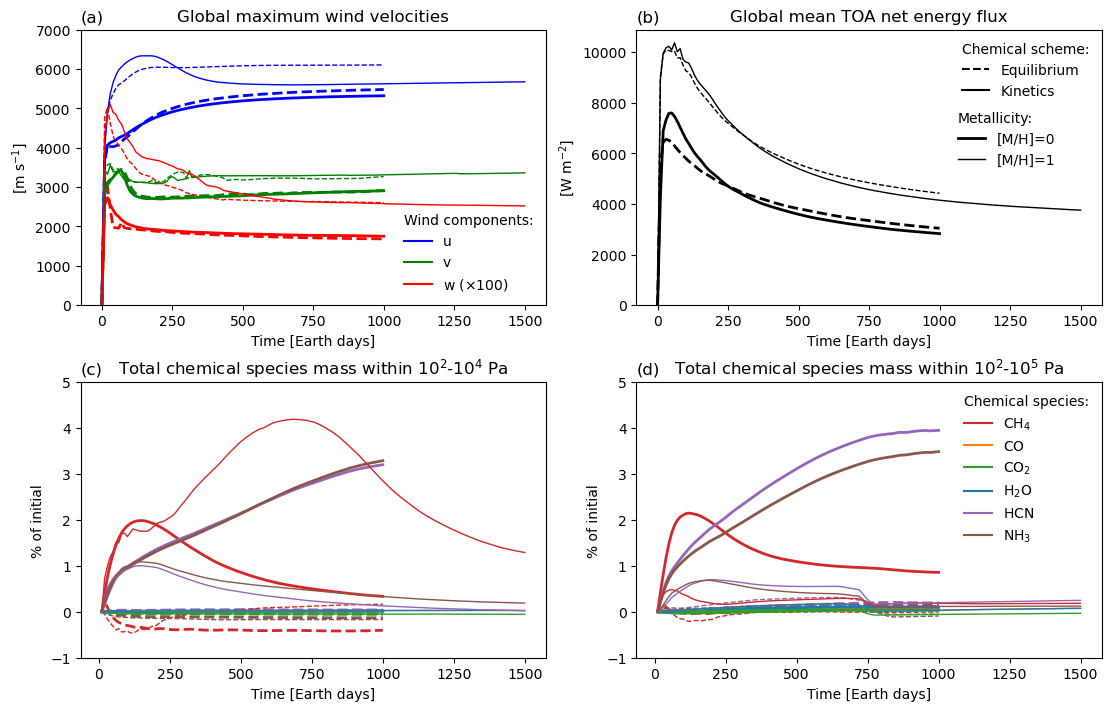

In [23]:
# Plot wind velocities, TOA net energy flux and chemical species total mass vs time
wind_lines = [
    Line2D([0], [0], color="b", ls="-"),
    Line2D([0], [0], color="g", ls="-"),
    Line2D([0], [0], color="r", ls="-"),
]
exp_lines = [
    Line2D([0], [0], color="k", ls="--"),
    Line2D([0], [0], color="k", ls="-"),
]
mdh_lines = [
    Line2D([0], [0], color="k", ls="-", lw=2),
    Line2D([0], [0], color="k", ls="-", lw=1),
]
gas_lines = [
    Line2D([0], [0], color="C3", ls="-"),
    Line2D([0], [0], color="C1", ls="-"),
    Line2D([0], [0], color="C2", ls="-"),
    Line2D([0], [0], color="C0", ls="-"),
    Line2D([0], [0], color="C4", ls="-"),
    Line2D([0], [0], color="C5", ls="-"),
]
pres_lines = [
    Line2D([0], [0], color="k", ls="-", alpha=1),
    Line2D([0], [0], color="k", ls="-", alpha=0.5),
]

fig, ax = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(11, 7))
for exp, ls in zip(["equilibrium", "kinetics"], ["dashed", "solid"]):
    for mdh, lw in zip(["mdh_0", "mdh_1"], [2, 1]):
        # Add initial state of rest
        plt_time_in_rel_days = np.concatenate(
            (np.array([0]), vrbls[planet][exp][mdh][tK]["time_in_rel_days"])
        )
        plt_u_max = np.concatenate((np.array([0]), vrbls[planet][exp][mdh][tK]["u_max"].data))
        plt_v_max = np.concatenate((np.array([0]), vrbls[planet][exp][mdh][tK]["v_max"].data))
        plt_w_max = np.concatenate((np.array([0]), vrbls[planet][exp][mdh][tK]["w_max"].data))
        plt_toa_net_mean = np.concatenate(
            (np.array([0]), vrbls[planet][exp][mdh][tK]["toa_net_mean"].data)
        )
        ax[0, 0].plot(
            plt_time_in_rel_days,
            plt_u_max,
            color="b",
            ls=ls,
            lw=lw,
        )
        ax[0, 0].plot(
            plt_time_in_rel_days,
            plt_v_max,
            color="g",
            ls=ls,
            lw=lw,
        )
        ax[0, 0].plot(
            plt_time_in_rel_days,
            plt_w_max,
            color="r",
            ls=ls,
            lw=lw,
        )
        ax[0, 1].plot(
            plt_time_in_rel_days,
            plt_toa_net_mean,
            color="k",
            ls=ls,
            lw=lw,
        )
        for gas in gases:
            ax[1, 0].plot(
                vrbls_burden[planet][exp][mdh][gas]["4"]["time_in_rel_days"],
                iris.pandas.as_series(vrbls_burden[planet][exp][mdh][gas]["4"]["burden"], copy=True)
                .pct_change()
                .fillna(0)
                .add(1)
                .cumprod()
                .sub(1),
                color=GASES[gas.upper()]["color"],
                ls=ls,
                lw=lw,
            )
            ax[1, 1].plot(
                vrbls_burden[planet][exp][mdh][gas]["5"]["time_in_rel_days"],
                iris.pandas.as_series(vrbls_burden[planet][exp][mdh][gas]["5"]["burden"], copy=True)
                .pct_change()
                .fillna(0)
                .add(1)
                .cumprod()
                .sub(1),
                color=GASES[gas.upper()]["color"],
                ls=ls,
                lw=lw,
            )
ax[0, 0].set_title("(a)", loc="left")
ax[0, 0].set_title("Global maximum wind velocities", loc="center")
ax[0, 0].set_ylabel("[m $s^{-1}$]")
ax[0, 0].set_ylim(0, 7000)

ax[0, 1].set_title(f"(b)", loc="left")
ax[0, 1].set_title("Global mean TOA net energy flux", loc="center")
ax[0, 1].set_ylabel("[W $m^{-2}$]")
ax[0, 1].set_ylim(bottom=0)

ax[1, 0].set_title("(c)", loc="left")
ax[1, 1].set_title("(d)", loc="left")
ax[1, 0].set_title("Total chemical species mass within $10^2$-$10^4$ Pa", loc="center")
ax[1, 1].set_title("Total chemical species mass within $10^2$-$10^5$ Pa", loc="center")
ax[1, 0].set_ylabel(f"% of initial")
ax[1, 1].set_ylabel(f"% of initial")
ax[1, 0].set_ylim(-1, 5)
ax[1, 1].set_ylim(-1, 5)

for iax in ax.flatten():
    iax.set_xlabel("Time [Earth days]")
    iax.set_xticks(np.arange(0, 1600, 250))
    iax.set_xticklabels(np.arange(0, 1600, 250))

# Legends
wind_leg = ax[0, 0].legend(
    wind_lines,
    ["u", "v", r"w ($\times100$)"],
    title="Wind components:",
    frameon=False,
    alignment="left",
    loc="lower right",
)
exp_leg = ax[0, 1].legend(
    exp_lines,
    ["Equilibrium", "Kinetics"],
    title="Chemical scheme:",
    frameon=False,
    alignment="left",
    loc="upper right",
)
axleg = ax[0, 1].add_artist(exp_leg)
mdh_leg = ax[0, 1].legend(
    mdh_lines,
    ["[M/H]=0", "[M/H]=1"],
    title="Metallicity:",
    frameon=False,
    alignment="left",
    bbox_to_anchor=(0.927, 0.75),
)
gas_leg = ax[1, 1].legend(
    gas_lines,
    ["$CH_4$", "$CO$", "$CO_2$", "$H_2O$", "$HCN$", "$NH_3$"],
    title="Chemical species:",
    frameon=False,
    alignment="left",
    loc="upper right",
)
figname_png = f"{planet}_steady_state.png"
figname_pdf = f"{planet}_steady_state.pdf"
fig.savefig(path_to_project / "steady_state" / figname_png, dpi=200)
fig.savefig(path_to_project / "steady_state" / figname_pdf, format="pdf")